In [1]:
import pandas as pd
import os
import numpy as np
import torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel
from PIL import Image
from torchvision.models import resnet50
from torch import nn
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report

In [2]:
df = pd.read_csv(r"C:\Users\HP\Desktop\meme_project\meme_1.csv").dropna()
df

,image,text,label_name,label
0,1000161298.jpg,"ಹುಡಗ ವಾಂತಿ ಮಾಡಿದ್ರ\n""BB ಬಂದಿನೂ ಮನೆಹಾಳ” ಅಂತಾರ,\...",hateful,1
1,1000161301.jpg,ಸಾಲ ಮಾಡೋದು ಸವಾಸ ದೋಷದಿಂದ ಅಂತೆ ಬರೋದು ಹೌದ\n,non-hateful,0
2,1000161304.jpg,ಮುಂದೆ ಅತ್ತಿ ಆದಾಗ ಸೊಸೆ ಇಷ್ಟ.\nಆಗಲ್ಲ,hateful,1
3,1000161307.jpg,ರೀ ನಂದಿನಿ ಅವೋ ನೀವು 21 AGE ಅಲ್ಲಿ ಬೆನ್ನು ನನ್ನು ಅ...,non-hateful,0
4,1000161336.jpg,ಕಾಲೇಜಿನಲ್ಲಿ ಇಂಗ್ಲಿಷ್ ತರಗತಿ ನಡೆಯುತ್ತಿತ್ತು. ಗುಂಡ...,non-hateful,0
...,...,...,...,...
135,images (72).jpeg,ಮುಖವಾ ನೊಳಗೆ.\nನಿಯತ್ನಾಗೆಡಟಡ\nಇಲ್ಲಿ ನಿನಗೆ ಯಾವ ಬೆ...,non-hateful,0
136,images (74).jpeg,ಹುಡುಗ್ರು ಮಾತಲ್ಲೇ ಮನೆ\nಕಟ್ಟಾರೆ ಅಂತಾರೆ.\nಆದರೇ......,hateful,1
137,images (84).jpeg,ಕತ್ತಲ ಕಾಮುಕ ಕೇರಳದಲ್ಲಿ\nಲಾಕ್‌!,hateful,1
138,images (87).jpeg,ಕೈಗೆ ಕೊಟ್ರು\nಕ್ಯಾಚ್ ಹಿಡಿಯಲ್ಲೋ\nಯಾಕ್ರೋ ಉರಸ್ತೀರಾ,non-hateful,0


In [3]:
# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(df['label']), y=df['label'])
class_weights = torch.tensor(class_weights, dtype=torch.float)

In [4]:
# Load tokenizer and text model
tokenizer = AutoTokenizer.from_pretrained("ai4bharat/IndicBERTv2-MLM-only")
text_model = AutoModel.from_pretrained("ai4bharat/IndicBERTv2-MLM-only")

In [5]:
# Enhanced image transforms with augmentation
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor()
])

# Load image model
image_model = resnet50(pretrained=True)
image_model = nn.Sequential(*list(image_model.children())[:-1])

C:\Users\HP\anaconda3\envs\tf38\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\HP\anaconda3\envs\tf38\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [6]:
class MemeDataset(Dataset):
    def __init__(self, df, image_folder):
        self.df = df
        self.image_folder = image_folder

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image_path = os.path.join(self.image_folder, row['image'])
        image = Image.open(image_path).convert('RGB')
        image_tensor = transform(image)

        inputs = tokenizer(row['text'], return_tensors="pt", truncation=True, padding=True)
        text_emb = text_model(**inputs).last_hidden_state.mean(dim=1).squeeze()

        with torch.no_grad():
            image_emb = image_model(image_tensor.unsqueeze(0)).squeeze()

        label = torch.tensor(row['label'], dtype=torch.long)
        return torch.cat((image_emb, text_emb), dim=0), label

In [7]:

# Train-test split
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)

# Use raw strings for Windows file paths to avoid escape issues
image_folder = r"C:\Users\HP\Desktop\MEME"

# Create dataset and data loaders
train_dataset = MemeDataset(train_df, image_folder)
test_dataset = MemeDataset(test_df, image_folder)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, generator=torch.Generator().manual_seed(42))

#train_loader = DataLoader(train_dataset, batch_size=4)
test_loader = DataLoader(test_dataset, batch_size=4)


In [8]:
class MultiModalClassifier(nn.Module):
    def __init__(self):
        super(MultiModalClassifier, self).__init__()
        self.classifier = nn.Sequential(
            nn.Linear(2048 + 768, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 2)
        )

    def forward(self, x):
        return self.classifier(x)

model = MultiModalClassifier()
criterion = nn.CrossEntropyLoss(weight=class_weights, label_smoothing=0.1)
optimizer = torch.optim.Adam(list(model.parameters()) + list(text_model.parameters()), lr=1e-4)

In [9]:
import matplotlib.pyplot as plt

loss_history = []
lr_history = []

for epoch in range(5):
    model.train()
    total_loss = 0
    for inputs, labels in train_loader:
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        lr_history.append(optimizer.param_groups[0]['lr'])

    loss_history.append(total_loss)
    print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}")

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Epoch 1, Loss: 21.1018
Epoch 2, Loss: 19.8822
Epoch 3, Loss: 15.6942
Epoch 4, Loss: 11.2579
Epoch 5, Loss: 8.5917


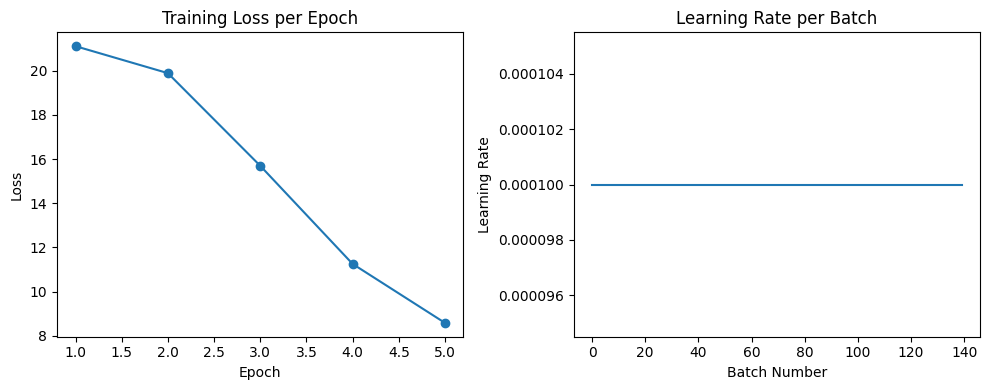

In [10]:
# Plotting learning curve
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(range(1, len(loss_history)+1), loss_history, marker='o')
plt.title('Training Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
plt.plot(lr_history, label='Learning Rate')
plt.title('Learning Rate per Batch')
plt.xlabel('Batch Number')
plt.ylabel('Learning Rate')
plt.tight_layout()
plt.show()

In [11]:
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.tolist())
        all_labels.extend(labels.tolist())

print(classification_report(all_labels, all_preds))

              precision    recall  f1-score   support

           0       0.71      0.94      0.81        18
           1       0.75      0.30      0.43        10

    accuracy                           0.71        28
   macro avg       0.73      0.62      0.62        28
weighted avg       0.72      0.71      0.67        28



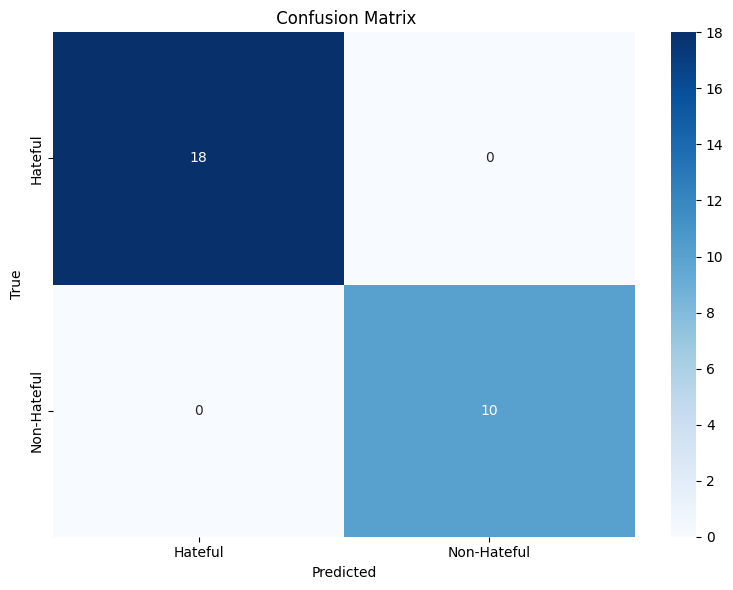

In [12]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(all_labels, all_preds), annot=True, fmt='d', cmap='Blues',
            xticklabels=['Hateful', 'Non-Hateful'], yticklabels=['Hateful', 'Non-Hateful'])
plt.title(" Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()
